
# Combining two FITS images with Reproject
***

By Nadia Steyn

This notebook uses the package Reproject to construct one mosaic from two separate FITS images. 

In this example, I am combining the MK16 Mosaic1 & Mosaic2 FITS files.

Documentation: https://reproject.readthedocs.io/en/stable/mosaicking.html

In [2]:
# All import statements
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from reproject.mosaicking import find_optimal_celestial_wcs, reproject_and_coadd
from reproject import reproject_interp, reproject_adaptive, reproject_exact
%matplotlib inline

# Read in the FITS images

In [3]:
# Import the two FITS files:
infile1 = "/Users/nadia/data/mosaic1.fits" # Change to your file directories and filenames
hdu1 = fits.open(infile1) # This FITS file has dimensions RA/Dec/Vel
reduced1 = hdu1[0].data[1032] # Read the data from the FITS file into an array, taking only one velocity slice

infile2 = "/Users/nadia/data/mosaic2_vin.fits"
hdu2 = fits.open(infile2) # This FITS file has dimensions RA/Dec/Vel
reduced2 = hdu2[0].data[1032]

plt.rcParams.update({'font.size': 15})

# See what the FITS files looks like individually

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


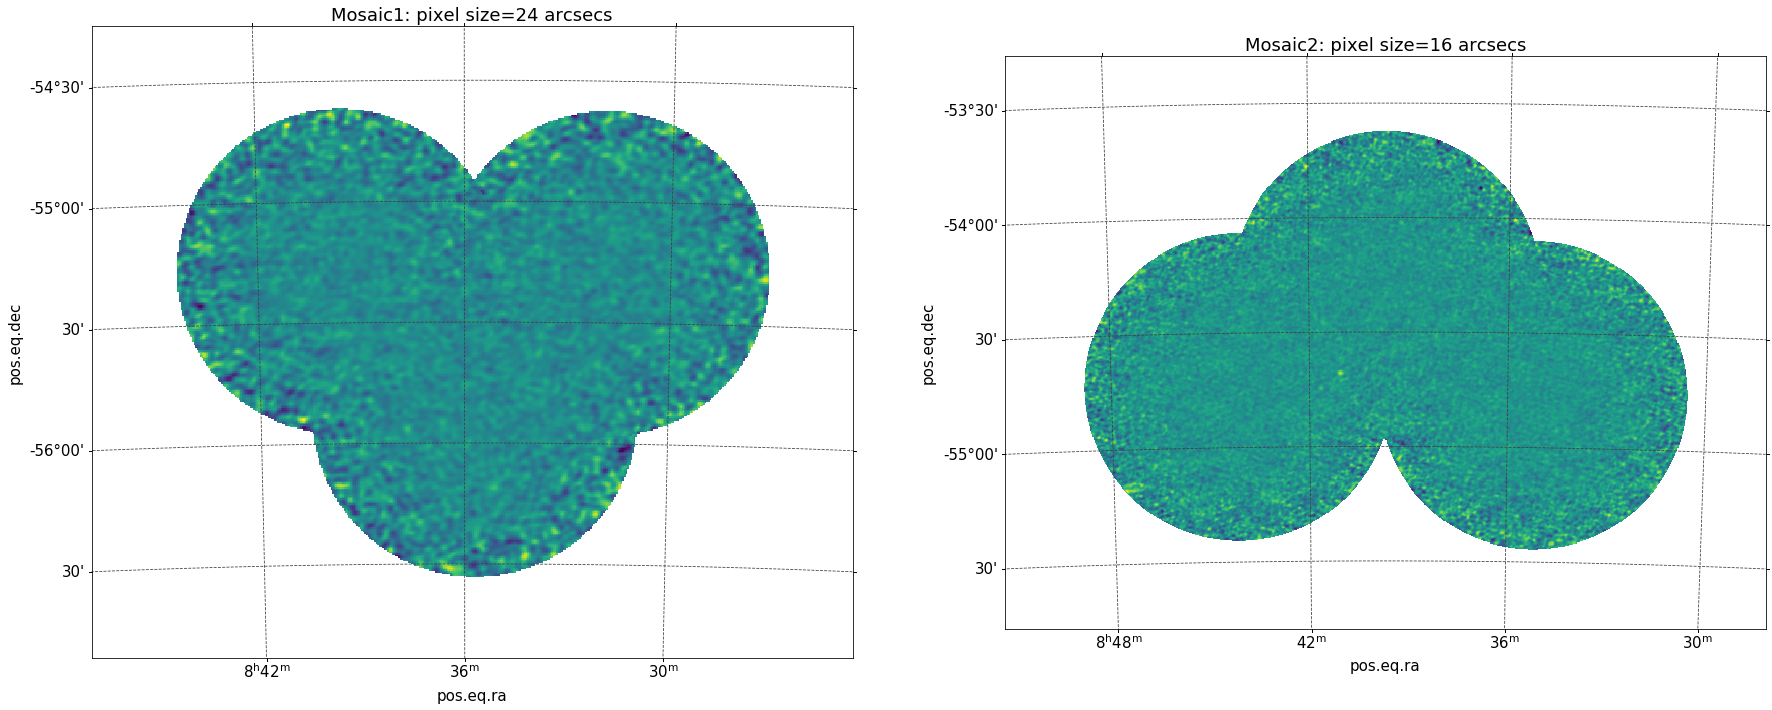

In [4]:
wcs1 = WCS(hdu1[0].header,naxis=2) # wcs projection for Mosaic1
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(121,projection=wcs1)
ax1.imshow(reduced1)
ax1.set_title("Mosaic1: pixel size=24 arcsecs")
plt.grid(color='0.25', ls='--')

wcs2 = WCS(hdu2[0].header,naxis=2) # wcs projection for Mosaic2
ax2 = fig.add_subplot(122,projection=wcs2)
ax2.imshow(reduced2)
ax2.set_title("Mosaic2: pixel size=16 arcsecs")
plt.grid(color='0.25', ls='--')

I want to plot these mosaics on the same axes so that I can see where they sit relative to each other. I can't overlay them as they are, because their WCS's are defined differently.

# The wrong way

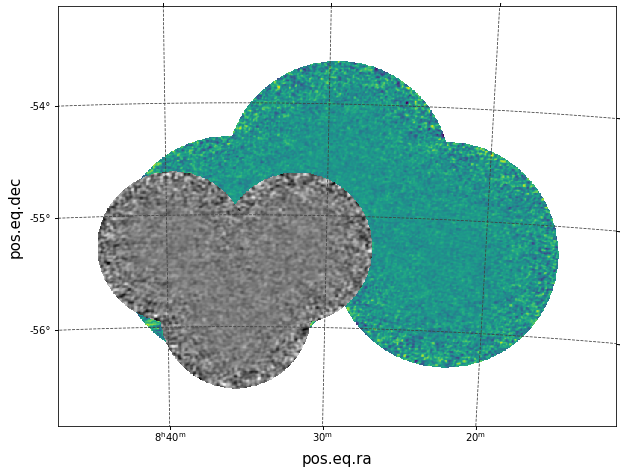

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=wcs1)
ax.imshow(reduced1,'gray',zorder=1) # Mosaic1 in grey for clarity
ax.imshow(reduced2,zorder=0)
plt.grid(color='0.25', ls='--')
plt.tick_params(axis='both',labelsize=10)

# Step 1: combine the two WCS's into one optimal WCS
documentation: https://reproject.readthedocs.io/en/stable/mosaicking.html

In [8]:
# The next function can be used to find an output WCS and shape (i.e. an output header) 
wcs_out, shape_out = find_optimal_celestial_wcs([(reduced1,wcs1),(reduced2,wcs2)])
# By default, the final mosaic will have the pixel resolution of the highest resolution input image 
    # You can over-ride this with 'resolution= x * u.arcsec'

# Step 2: choose a reprojection algorithm
Documentation: https://reproject.readthedocs.io/en/stable/celestial.html

In [9]:
# Three common reprojection algorithms:

reproject_function1 = reproject_interp
    # Reproject data to a new projection using simple interpolation 
    # this is typically the fastest way to reproject an image
    # the order of the interpolation can be controlled by setting the order= argument

reproject_function2 = reproject_adaptive
    # Reproject celestial slices from one WCS to another using the DeForest (2004) adaptive resampling algorithm

reproject_function3 = reproject_exact
    # Reproject data to a new projection using flux-conserving spherical polygon intersection 
    # this is the slowest algorithm
    # warning: reproject_exact() is currently known to have precision issues for images with resolutions <0.05”.

# Step 3: image reprojection
Documentation: https://reproject.readthedocs.io/en/stable/api/reproject.mosaicking.reproject_and_coadd.html

In [10]:
# I am choosing reproject_exact (although I can't recognise the difference)
# The following function returns the reprojected array:

array, _ = reproject_and_coadd([(reduced1,wcs1),(reduced2,wcs2)], wcs_out, \
                               shape_out=shape_out, reproject_function=reproject_function3)

# Now that the images are mosaicked together, we can make a plot

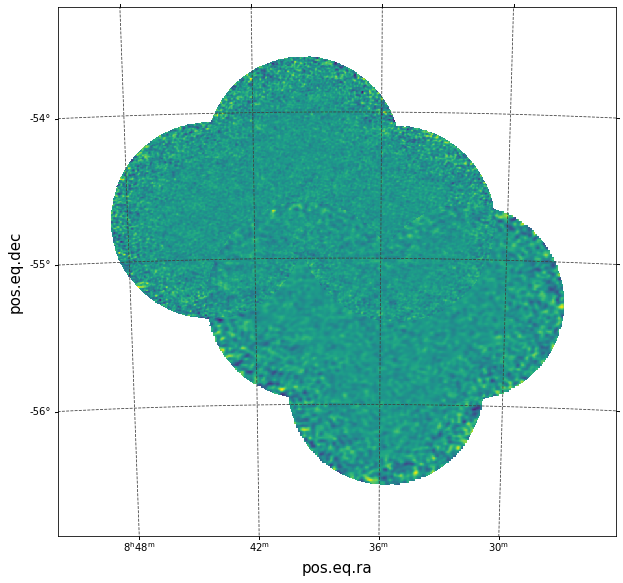

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=wcs_out)
ax.imshow(array)
plt.grid(color='0.25', ls='--')
plt.tick_params(axis='both',labelsize=10)

Disclaimer: I haven't studied the details of the reprojection algorithms. My intention was to plot the mosaics for aesthetic reasons, not to use it for analysis, e.g. to see where the images were relative to each other on-sky, and overlay other data such as their outlines or galaxy detections.